**Goal of the Code:** Create a plot to display the regional differences between a RFG and the RCP4.5 scenario for Transpiration. For this, a linear regression is calculated for each grid cell above land with FCTR of that gridcell as dependent and global mean temperature as independent variable. The linear regression is caculated twice, once for the mean of RFGs and once for RCP4.5. Plotted in the end is the difference between those linear regressions. To check for significant differences, the residuals are compared with a t-test and significant areas are hatched.

In [1]:
import numpy as np
from netCDF4 import Dataset

import iris
import iris.plot as iplt
import iris.coord_categorisation
import iris.analysis.cartography

import matplotlib.cm as mpl_cm
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as ccrs
import matplotlib.path as mpath

from scipy.stats import ttest_ind

import statsmodels.api as sm

## bounds for extent of the colour bar
bound = [6.2, -6.2]

Define function to calculate running mean of a time series where x = array and w = time span of running mean.

In [2]:
def moving_average(x, w): # x = array, w = 21 years
    return np.convolve(x, np.ones(w), 'valid') / w

Load the FCTR and TS files.  CCT03 starts 12 months after the other ensembles, hence why they start at 12. 

In [3]:
path = r"E:\Datasets_Geoengineering\JS_files_new_sel_var/"

CCT_Tmean_01 = iris.load(path + "TS_01_sel_var_CCT_cam.all.nc")[0][12:,:,:]
CCT_Tmean_02 = iris.load(path + "TS_02_sel_var_CCT_cam.all.nc")[0][12:,:,:]
CCT_Tmean_03 = iris.load(path + "TS_03_sel_var_CCT_cam.all.nc")[0][:,:,:]

MSB_Tmean_01 = iris.load(path + "TS_01_sel_var_MSB_cam.all.nc")[0][12:,:,:]
MSB_Tmean_02 = iris.load(path + "TS_02_sel_var_MSB_cam.all.nc")[0][12:,:,:]
MSB_Tmean_03 = iris.load(path + "TS_03_sel_var_MSB_cam.all.nc")[0][12:,:,:]

SAI_Tmean_01 = iris.load(path + "TS_01_sel_var_SAI_cam.all.nc")[0][12:,:,:]
SAI_Tmean_02 = iris.load(path + "TS_02_sel_var_SAI_cam.all.nc")[0][12:,:,:]
SAI_Tmean_03 = iris.load(path + "TS_03_sel_var_SAI_cam.all.nc")[0][12:,:,:]

RCP_Tmean = iris.load(r"E:\Datasets_Geoengineering\RCP45_variables\TS_RCP45_cam.all.nc")[0][:,:,:]

CCT_01 = iris.load(path + "FCTR_01_sel_var_CCT.all.nc")[0][12:,:,:].data
CCT_02 = iris.load(path + "FCTR_02_sel_var_CCT.all.nc")[0][12:,:,:].data
CCT_03 = iris.load(path + "FCTR_03_sel_var_CCT.all.nc")[0][:,:,:].data


MSB_01 = iris.load(path + "FCTR_01_sel_var_MSB.all.nc")[0][12:,:,:].data
MSB_02 = iris.load(path + "FCTR_02_sel_var_MSB.all.nc")[0][12:,:,:].data
MSB_03 = iris.load(path + "FCTR_03_sel_var_MSB.all.nc")[0][12:,:,:].data


SAI_01 = iris.load(path + "FCTR_01_sel_var_SAI.all.nc")[0][12:,:,:].data
SAI_02 = iris.load(path + "FCTR_02_sel_var_SAI.all.nc")[0][12:,:,:].data
SAI_03 = iris.load(path + "FCTR_03_sel_var_SAI.all.nc")[0][12:,:,:].data

RCP_01 = iris.load(r"E:\Datasets_Geoengineering\RCP45_variables\FCTR_RCP45.all.nc")[0][:,:,:].data

To calculate the global mean temperature, T$_{mean}$ needs to be cosine weighted.

In [4]:
import warnings
warnings.filterwarnings("ignore") ## To ignore UserWarning about collapsing a non-contagious variable

CCT_01_weigh = iris.analysis.cartography.cosine_latitude_weights(CCT_Tmean_01)
CCT_Tmean_01_weigh_mean = CCT_Tmean_01.collapsed(["latitude","longitude"], iris.analysis.MEAN, weights = CCT_01_weigh).data 
CCT_02_weigh = iris.analysis.cartography.cosine_latitude_weights(CCT_Tmean_02)
CCT_Tmean_02_weigh_mean = CCT_Tmean_02.collapsed(["latitude","longitude"], iris.analysis.MEAN, weights = CCT_02_weigh).data 
CCT_03_weigh = iris.analysis.cartography.cosine_latitude_weights(CCT_Tmean_03)
CCT_Tmean_03_weigh_mean = CCT_Tmean_03.collapsed(["latitude","longitude"], iris.analysis.MEAN, weights = CCT_03_weigh).data

MSB_01_weigh = iris.analysis.cartography.cosine_latitude_weights(MSB_Tmean_01)
MSB_Tmean_01_weigh_mean = MSB_Tmean_01.collapsed(["latitude","longitude"], iris.analysis.MEAN, weights = MSB_01_weigh).data 
MSB_02_weigh = iris.analysis.cartography.cosine_latitude_weights(MSB_Tmean_02)
MSB_Tmean_02_weigh_mean = MSB_Tmean_02.collapsed(["latitude","longitude"], iris.analysis.MEAN, weights = MSB_02_weigh).data 
MSB_03_weigh = iris.analysis.cartography.cosine_latitude_weights(MSB_Tmean_03)
MSB_Tmean_03_weigh_mean = MSB_Tmean_03.collapsed(["latitude","longitude"], iris.analysis.MEAN, weights = MSB_03_weigh).data

SAI_01_weigh = iris.analysis.cartography.cosine_latitude_weights(SAI_Tmean_01)
SAI_Tmean_01_weigh_mean = SAI_Tmean_01.collapsed(["latitude","longitude"], iris.analysis.MEAN, weights = SAI_01_weigh).data 
SAI_02_weigh = iris.analysis.cartography.cosine_latitude_weights(SAI_Tmean_02)
SAI_Tmean_02_weigh_mean = SAI_Tmean_02.collapsed(["latitude","longitude"], iris.analysis.MEAN, weights = SAI_02_weigh).data 
SAI_03_weigh = iris.analysis.cartography.cosine_latitude_weights(SAI_Tmean_03)
SAI_Tmean_03_weigh_mean = SAI_Tmean_03.collapsed(["latitude","longitude"], iris.analysis.MEAN, weights = SAI_03_weigh).data 

RCP_weigh = iris.analysis.cartography.cosine_latitude_weights(RCP_Tmean)
RCP_Tmean_weigh_mean = RCP_Tmean.collapsed(["latitude","longitude"], iris.analysis.MEAN, weights = RCP_weigh).data 

In [5]:
CCT_Tmean_01_array = CCT_Tmean_01_weigh_mean.data
CCT_Tmean_01_list = CCT_Tmean_01_array.tolist()
CCT_Tmean_03_array = CCT_Tmean_03_weigh_mean.data
CCT_Tmean_03_list = CCT_Tmean_03_array.tolist()
CCT_Tmean_02_array = CCT_Tmean_02_weigh_mean.data
CCT_Tmean_02_list = CCT_Tmean_02_array.tolist()

MSB_Tmean_01_array = MSB_Tmean_01_weigh_mean.data
MSB_Tmean_01_list = MSB_Tmean_01_array.tolist()
MSB_Tmean_03_array = MSB_Tmean_03_weigh_mean.data
MSB_Tmean_03_list = MSB_Tmean_03_array.tolist()
MSB_Tmean_02_array = MSB_Tmean_02_weigh_mean.data
MSB_Tmean_02_list = MSB_Tmean_02_array.tolist()

SAI_Tmean_01_array = SAI_Tmean_01_weigh_mean.data
SAI_Tmean_01_list = SAI_Tmean_01_array.tolist()
SAI_Tmean_03_array = SAI_Tmean_03_weigh_mean.data
SAI_Tmean_03_list = SAI_Tmean_03_array.tolist()
SAI_Tmean_02_array = SAI_Tmean_02_weigh_mean.data
SAI_Tmean_02_list = SAI_Tmean_02_array.tolist()

For each RFG ensemble, the yearly mean of global T$_{mean}$ is calculated.

In [6]:
CCT_Tmean_year_mean_01 = []
CCT_Tmean_year_mean_02 = []
CCT_Tmean_year_mean_03 = []
MSB_Tmean_year_mean_01 = []
MSB_Tmean_year_mean_02 = []
MSB_Tmean_year_mean_03 = []
SAI_Tmean_year_mean_01 = []
SAI_Tmean_year_mean_02 = []
SAI_Tmean_year_mean_03 = []

i = 0
while i in range(0, len(CCT_Tmean_01_list)):
    CCT_Tmean_year_mean_01.append(np.mean(CCT_Tmean_01_list[i:i+12]))
    CCT_Tmean_year_mean_02.append(np.mean(CCT_Tmean_02_list[i:i+12]))
    CCT_Tmean_year_mean_03.append(np.mean(CCT_Tmean_03_list[i:i+12]))
    MSB_Tmean_year_mean_01.append(np.mean(MSB_Tmean_01_list[i:i+12]))
    MSB_Tmean_year_mean_02.append(np.mean(MSB_Tmean_02_list[i:i+12]))
    MSB_Tmean_year_mean_03.append(np.mean(MSB_Tmean_03_list[i:i+12]))
    SAI_Tmean_year_mean_01.append(np.mean(SAI_Tmean_01_list[i:i+12]))
    SAI_Tmean_year_mean_02.append(np.mean(SAI_Tmean_02_list[i:i+12]))
    SAI_Tmean_year_mean_03.append(np.mean(SAI_Tmean_03_list[i:i+12]))
    i = i + 12

RCP_Tmean_year_mean = []

i = 0
while i in range(0,len(RCP_Tmean_weigh_mean)):
    RCP_Tmean_year_mean.append(np.mean(RCP_Tmean_weigh_mean[i:i+12].data))
    i = i + 12

Calculate the 21-year running mean for each dataset.

In [7]:
CCT_Tmean_Roll_mean_01 = moving_average(CCT_Tmean_year_mean_01, 21)
CCT_Tmean_Roll_mean_02 = moving_average(CCT_Tmean_year_mean_02, 21)
CCT_Tmean_Roll_mean_03 = moving_average(CCT_Tmean_year_mean_03, 21)
MSB_Tmean_Roll_mean_01 = moving_average(MSB_Tmean_year_mean_01, 21)
MSB_Tmean_Roll_mean_02 = moving_average(MSB_Tmean_year_mean_02, 21)
MSB_Tmean_Roll_mean_03 = moving_average(MSB_Tmean_year_mean_03, 21)
SAI_Tmean_Roll_mean_01 = moving_average(SAI_Tmean_year_mean_01, 21)
SAI_Tmean_Roll_mean_02 = moving_average(SAI_Tmean_year_mean_02, 21)
SAI_Tmean_Roll_mean_03 = moving_average(SAI_Tmean_year_mean_03, 21)
RCP_Tmean_Roll_mean = moving_average(RCP_Tmean_year_mean, 21)

Open three datasets. Landmask is a random file that contains a landmask to later only iterate over the gridcells that are on land. Data is a nc file used to store the slopes and pval_data is a nc file used to store the p-values.

In [8]:
path = r"E:\Datasets_Geoengineering\JS_files_new_sel_var/"
path2 = r"E:\Datasets_Geoengineering\Lin_Reg_Files/"

landmask = iris.load(path + "TSA_01_sel_var_MSB.all.nc")[0][:,:,:]
data = Dataset(path2 + "LHFLX_01_sel_var_all_RFG.all.nc", "a")
pval_data = Dataset(path2 + "LHFLX_01_sel_var_all_RFG_pval.all.nc", "a")

Iterate over all land gridcells. For each gridcell and ensemble, the mean latent heat flux of each boreal summer (JJA) is calculated and stored in a list. A 21-year running mean of that list is calculated. Then, for each ensemble and gridcell, a linear regression is calculated between the latent heat time series of that gridcell (y) and the global mean temperature time series calculated above (x). The mean-value of the slopes for each RFG is calculated and the slope calculated for RCP4.5 is subtracted. This difference is stored in data for each gridcell. (0 = CCT, 1 = MSB, 2 = SAI)

To test for significant difference between RCP4.5 and each RFG the residual deviation from the linear regression of the RFGs b is calculated for each ensemble, three times with the slope and intercept of the RCP8.5 linear regression and three with the slope and intercept of each linear regression of the ensembles of each RFG with x and y of the RFG ensembles. This is calculated for the last 20 years of the time series. The results are stored in six lists, once for RFG and once for RCP4.5, hence for each RFG twice. The two lists are tested for significant differences by the means of an independent t-test.

In [9]:
for lat in range(0,96):
    for lon in range(0,144):
            if landmask.data.mask[0,lat,lon] == False:
                CCT_year_mean_01 = []
                CCT_year_mean_02 = []
                CCT_year_mean_03 = []
                MSB_year_mean_01 = []
                MSB_year_mean_02 = []
                MSB_year_mean_03 = []
                SAI_year_mean_01 = []
                SAI_year_mean_02 = []
                SAI_year_mean_03 = []
                RCP_year_mean = []
                i = 0
                while i in range(0, len(CCT_01)):

                    CCT_year_mean_01.append(np.mean(CCT_01[5+i:8+i, lat, lon].data))
                    CCT_year_mean_02.append(np.mean(CCT_02[5+i:8+i, lat, lon].data))
                    CCT_year_mean_03.append(np.mean(CCT_03[5+i:8+i, lat, lon].data))
                    MSB_year_mean_01.append(np.mean(MSB_01[5+i:8+i, lat, lon].data))
                    MSB_year_mean_02.append(np.mean(MSB_02[5+i:8+i, lat, lon].data))
                    MSB_year_mean_03.append(np.mean(MSB_03[5+i:8+i, lat, lon].data))
                    SAI_year_mean_01.append(np.mean(SAI_01[5+i:8+i, lat, lon].data))
                    SAI_year_mean_02.append(np.mean(SAI_02[5+i:8+i, lat, lon].data))
                    SAI_year_mean_03.append(np.mean(SAI_03[5+i:8+i, lat, lon].data))
                    i = i + 12
                i = 0
                while i in range(0, len(RCP_01)):
                    RCP_year_mean.append(np.mean(RCP_01[5+i:8+i, lat, lon].data))
                    i = i + 12

                CCT_Roll_mean_01 = moving_average(CCT_year_mean_01, 21)
                CCT_Roll_mean_02 = moving_average(CCT_year_mean_02, 21)
                CCT_Roll_mean_03 = moving_average(CCT_year_mean_03, 21)
                MSB_Roll_mean_01 = moving_average(MSB_year_mean_01, 21)
                MSB_Roll_mean_02 = moving_average(MSB_year_mean_02, 21)
                MSB_Roll_mean_03 = moving_average(MSB_year_mean_03, 21)
                SAI_Roll_mean_01 = moving_average(SAI_year_mean_01, 21)
                SAI_Roll_mean_02 = moving_average(SAI_year_mean_02, 21)
                SAI_Roll_mean_03 = moving_average(SAI_year_mean_03, 21)
                RCP_Roll_mean = moving_average(RCP_year_mean, 21)

                
                ## -- RFG Linear Regression -- ##

                y = (CCT_Roll_mean_01)
                x1 = CCT_Tmean_Roll_mean_01
                x = sm.add_constant(x1)
                model_RFG = sm.OLS(y,x, missing = "drop")
                results_RFG = model_RFG.fit()
                slope_CCT_01 = results_RFG.params[1]
                int_CCT_01 = results_RFG.params[0]

                y = (CCT_Roll_mean_02)
                x1 = CCT_Tmean_Roll_mean_02
                x = sm.add_constant(x1)
                model_RFG = sm.OLS(y,x, missing = "drop")
                results_RFG = model_RFG.fit()
                slope_CCT_02 = results_RFG.params[1]
                int_CCT_02 = results_RFG.params[0]

                y = (CCT_Roll_mean_03)
                x1 = CCT_Tmean_Roll_mean_03
                x = sm.add_constant(x1)
                model_RFG = sm.OLS(y,x, missing = "drop")
                results_RFG = model_RFG.fit()
                slope_CCT_03 = results_RFG.params[1]
                int_CCT_03 = results_RFG.params[0]

                y = (MSB_Roll_mean_01)
                x1 = MSB_Tmean_Roll_mean_01
                x = sm.add_constant(x1)
                model_RFG = sm.OLS(y,x, missing = "drop")
                results_RFG = model_RFG.fit()
                slope_MSB_01 = results_RFG.params[1]
                int_MSB_01 = results_RFG.params[0]

                y = (MSB_Roll_mean_02)
                x1 = MSB_Tmean_Roll_mean_02
                x = sm.add_constant(x1)
                model_RFG = sm.OLS(y,x, missing = "drop")
                results_RFG = model_RFG.fit()
                slope_MSB_02 = results_RFG.params[1]
                int_MSB_02 = results_RFG.params[0]

                y = (MSB_Roll_mean_03)
                x1 = MSB_Tmean_Roll_mean_03
                x = sm.add_constant(x1)
                model_RFG = sm.OLS(y,x, missing = "drop")
                results_RFG = model_RFG.fit()
                slope_MSB_03 = results_RFG.params[1]
                int_MSB_03 = results_RFG.params[0]

                y = (SAI_Roll_mean_01)
                x1 = SAI_Tmean_Roll_mean_01
                x = sm.add_constant(x1)
                model_RFG = sm.OLS(y,x, missing = "drop")
                results_RFG = model_RFG.fit()
                slope_SAI_01 = results_RFG.params[1]
                int_SAI_01 = results_RFG.params[0]

                y = (SAI_Roll_mean_02)
                x1 = SAI_Tmean_Roll_mean_02
                x = sm.add_constant(x1)
                model_RFG = sm.OLS(y,x, missing = "drop")
                results_RFG = model_RFG.fit()
                slope_SAI_02 = results_RFG.params[1]
                int_SAI_02 = results_RFG.params[0]

                y = (SAI_Roll_mean_03)
                x1 = SAI_Tmean_Roll_mean_03
                x = sm.add_constant(x1)
                model_RFG = sm.OLS(y,x, missing = "drop")
                results_RFG = model_RFG.fit()
                slope_SAI_03 = results_RFG.params[1]
                int_SAI_03 = results_RFG.params[0]

                slope_CCT = (slope_CCT_01 + slope_CCT_02+ slope_CCT_03) / 3 
                slope_MSB = (slope_MSB_01 + slope_MSB_02+ slope_MSB_03) / 3 
                slope_SAI = (slope_SAI_01 + slope_SAI_02+ slope_SAI_03) / 3 

                ## -- RCP Linear Regression -- ##

                y = RCP_Roll_mean
                x1 = RCP_Tmean_Roll_mean
                x = sm.add_constant(x1)

                model_RCP = sm.OLS(y,x, missing = "drop")
                results_RCP = model_RCP.fit()
                slope_RCP = results_RCP.params[1]

                slope_RCP_CCT = slope_CCT - slope_RCP
                slope_RCP_MSB = slope_MSB - slope_RCP
                slope_RCP_SAI = slope_SAI - slope_RCP
                
                ## if slope is > bound, the colour that will be assigned will be the "maximum" colour
                if slope_RCP_CCT > bound[0]:
                    data.variables["RAIN"][0,lat,lon] = bound[0]
                elif slope_RCP_CCT < bound[1]:
                    data.variables["RAIN"][0,lat,lon] = bound[1]
                else:
                    data.variables["RAIN"][0,lat,lon] = slope_RCP_CCT
                    
                if slope_RCP_MSB > bound[0]:
                    data.variables["RAIN"][1,lat,lon] = bound[0]
                elif slope_RCP_MSB < bound[1]:
                    data.variables["RAIN"][1,lat,lon] = bound[1]
                else:
                    data.variables["RAIN"][1,lat,lon] = slope_RCP_MSB
                    
                if slope_RCP_SAI > bound[0]:
                    data.variables["RAIN"][2,lat,lon] = bound[0]
                elif slope_RCP_SAI < bound[1]:
                    data.variables["RAIN"][2,lat,lon] = bound[1]
                else:
                    data.variables["RAIN"][2,lat,lon] = slope_RCP_SAI

                    
                n = len(RCP_Roll_mean) - len(CCT_Roll_mean_01)
                RCP_Roll_mean = RCP_Roll_mean[n:]
                RCP_Tmean_Roll_mean_new = RCP_Tmean_Roll_mean[n:]

                b_RCP_CCT = []
                b_RCP_MSB = []
                b_RCP_SAI = []
                b_RFG_CCT = []
                b_RFG_MSB = []
                b_RFG_SAI = []

                for i in range(len(RCP_Roll_mean) - 21, len(RCP_Roll_mean) - 1):                        
                    b_RCP_CCT.append(CCT_Roll_mean_01[i] - slope_RCP * CCT_Tmean_Roll_mean_01[i] - results_RCP.params[0])
                    b_RCP_CCT.append(CCT_Roll_mean_02[i] - slope_RCP * CCT_Tmean_Roll_mean_02[i] - results_RCP.params[0])
                    b_RCP_CCT.append(CCT_Roll_mean_03[i] - slope_RCP * CCT_Tmean_Roll_mean_03[i] - results_RCP.params[0])
                    b_RCP_MSB.append(MSB_Roll_mean_01[i] - slope_RCP * MSB_Tmean_Roll_mean_01[i] - results_RCP.params[0])
                    b_RCP_MSB.append(MSB_Roll_mean_02[i] - slope_RCP * MSB_Tmean_Roll_mean_02[i] - results_RCP.params[0])
                    b_RCP_MSB.append(MSB_Roll_mean_03[i] - slope_RCP * MSB_Tmean_Roll_mean_03[i] - results_RCP.params[0])
                    b_RCP_SAI.append(SAI_Roll_mean_01[i] - slope_RCP * SAI_Tmean_Roll_mean_01[i] - results_RCP.params[0])
                    b_RCP_SAI.append(SAI_Roll_mean_02[i] - slope_RCP * SAI_Tmean_Roll_mean_02[i] - results_RCP.params[0])
                    b_RCP_SAI.append(SAI_Roll_mean_03[i] - slope_RCP * SAI_Tmean_Roll_mean_03[i] - results_RCP.params[0])
                    b_RFG_CCT.append(CCT_Roll_mean_01[i] - slope_CCT_01 * CCT_Tmean_Roll_mean_01[i] - int_CCT_01)
                    b_RFG_CCT.append(CCT_Roll_mean_02[i] - slope_CCT_02 * CCT_Tmean_Roll_mean_02[i] - int_CCT_02)
                    b_RFG_CCT.append(CCT_Roll_mean_03[i] - slope_CCT_03 * CCT_Tmean_Roll_mean_03[i] - int_CCT_03)
                    b_RFG_MSB.append(MSB_Roll_mean_01[i] - slope_MSB_01 * MSB_Tmean_Roll_mean_01[i] - int_MSB_01)
                    b_RFG_MSB.append(MSB_Roll_mean_02[i] - slope_MSB_02 * MSB_Tmean_Roll_mean_02[i] - int_MSB_02)
                    b_RFG_MSB.append(MSB_Roll_mean_03[i] - slope_MSB_03 * MSB_Tmean_Roll_mean_03[i] - int_MSB_03)
                    b_RFG_SAI.append(SAI_Roll_mean_01[i] - slope_SAI_01 * SAI_Tmean_Roll_mean_01[i] - int_SAI_01)
                    b_RFG_SAI.append(SAI_Roll_mean_02[i] - slope_SAI_02 * SAI_Tmean_Roll_mean_02[i] - int_SAI_02)
                    b_RFG_SAI.append(SAI_Roll_mean_03[i] - slope_SAI_03 * SAI_Tmean_Roll_mean_03[i] - int_SAI_03)

                t_test = ttest_ind(b_RCP_CCT, b_RFG_CCT) ## unpaired t-test
                p_val = t_test.pvalue
                pval_data.variables["RAIN"][0,lat,lon] = p_val
                
                t_test = ttest_ind(b_RCP_MSB, b_RFG_MSB) ## unpaired t-test
                p_val = t_test.pvalue
                pval_data.variables["RAIN"][1,lat,lon] = p_val
                
                t_test = ttest_ind(b_RCP_SAI, b_RFG_SAI) ## unpaired t-test
                p_val = t_test.pvalue
                pval_data.variables["RAIN"][2,lat,lon] = p_val

The first two lines are to control the extent of the colourbar. Line 3 and 4 close the two nc files.

In [10]:
data.variables["RAIN"][0:3,90,21] = bound[0]
data.variables["RAIN"][0:3,90,20] = bound[1]
data.close()
pval_data.close()

Plotting of the maps with hatching of the non-significant (p-value > 0.05) areas in a north polar stereo projection.  By changing RFG, a different RFG will be plotted

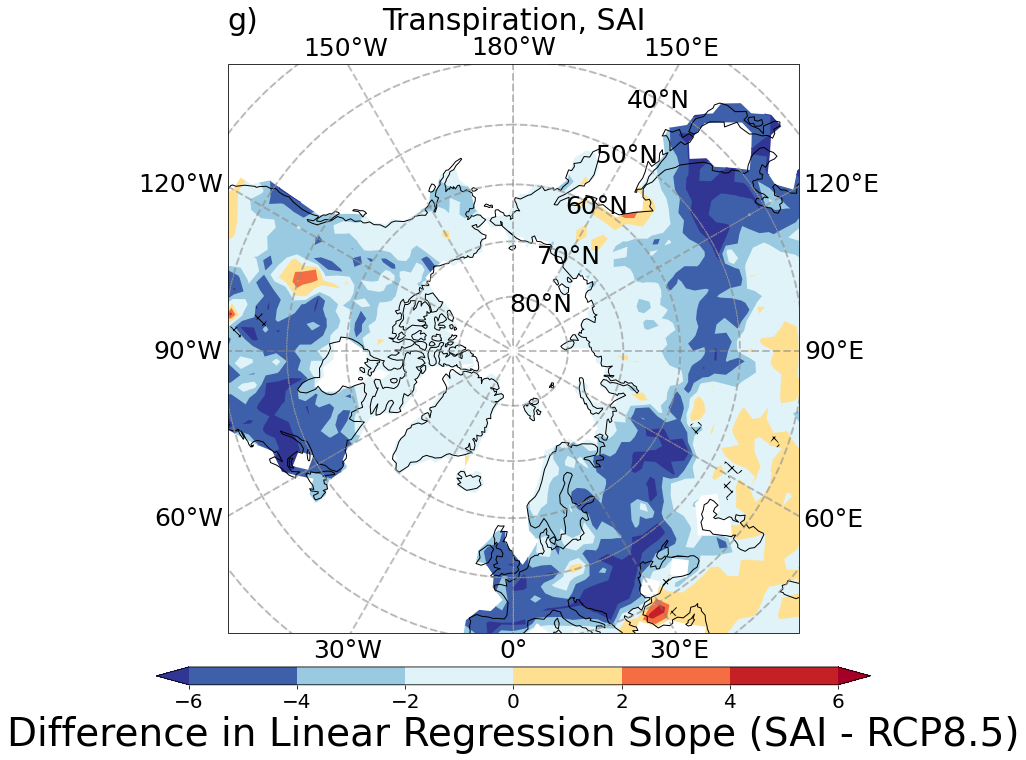

In [13]:

RFG = 2 ## 0 = CCT, 1 = MCB, 2 = SAI
RFG_names = ["CCT", "MCB", "SAI"]
title_letter = ["a)", "d)", "g)"]

matplotlib.rcParams.update({'font.size': 20})

path2 = r"E:\Datasets_Geoengineering\Lin_Reg_Files/"

RFG_plot = iris.load(path2 + "LHFLX_01_sel_var_all_RFG.all.nc")[0]
P_val = iris.load(path2 + "LHFLX_01_sel_var_all_RFG_pval.all.nc")[0]
RFG_plot.data.mask = landmask.data.mask
P_val.data.mask = landmask.data.mask
for lat in range(0, 96):
    for lon in range(0,144):
        if P_val[RFG,lat,lon].data < 0.05:
            P_val.data.mask[RFG,lat,lon] = True

brewer_cmap = mpl_cm.get_cmap("brewer_RdBu_11")
cmap = mpl_cm.get_cmap('RdYlBu_r', 16) 


matplotlib.rcParams.update({'font.size': 39})
 
fig=plt.figure(figsize=(10,10), constrained_layout = True)
ax = plt.subplot(111,projection = ccrs.NorthPolarStereo())


ax.gridlines(color='lightgray',linestyle='--',linewidth=0.5)
fig = iplt.contourf(RFG_plot[RFG, 50:,:], cmap=cmap, extend = "both", projection=ccrs.NorthPolarStereo())
fig2 = iplt.contourf(P_val[RFG, 50:,:], alpha=0, hatches = ['xx'], colors = 'none',projection=ccrs.NorthPolarStereo())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=2, color='gray', alpha=0.5, linestyle='--')
#cb = plt.colorbar(fig, orientation="horizontal", pad = 0.05, extend = "both", aspect=40)
#cb.set_label(label = "Difference in Linear Regression Slope (" + RFG_names[RFG] +" - RCP8.5)")
#cb.ax.tick_params(labelsize=20)
ax.set_extent((-180,180,40.5,90),crs = ccrs.PlateCarree())
plt.gca().coastlines()
plt.title("Transpiration, " + RFG_names[RFG], fontsize = 30)
plt.title(title_letter[RFG],  loc = "left", fontsize = 30)

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

gl.xlocator = mticker.FixedLocator(np.concatenate([np.arange(-180,181-30,30)]))
gl.xformatter = LONGITUDE_FORMATTER
gl.xlabel_style = {'color': 'k','rotation':0, "size":25}
gl.ylabel_style = {"size":25}

figure = plt.gcf()

#plt.savefig(r"C:\Users\rhonda\OneDrive\Dokumente\Uni-DESKTOP-8400FCB\Master Thesis\Figures for Paper\Fig2_" + RFG_names[RFG] +"_Tran.jpg",bbox_inches='tight')
